In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix, classification_report, roc_curve, auc
from scipy.stats import mstats
import warnings
import pickle
import os

warnings.filterwarnings("ignore")

## Load the Dataset

In [41]:
file_path = 'Multiple Classification - EV Battery Faults Dataset.xlsx'
df = pd.read_excel(file_path)

## Step 1: Exploratory Data Analysis (EDA)

In [42]:
print("Dataset Info:")
print(df.info())
print("\nFirst 5 Rows:")
print(df.head())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1152 entries, 0 to 1151
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   SoC          1152 non-null   float64
 1   Temperature  1152 non-null   float64
 2   Voltage      1152 non-null   float64
 3   Label        1152 non-null   int64  
dtypes: float64(3), int64(1)
memory usage: 36.1 KB
None

First 5 Rows:
          SoC  Temperature   Voltage  Label
0  100.000000   298.150000  4.014300      0
1   99.173138   298.849283  3.916820      0
2   98.346276   299.665201  3.887562      0
3   97.519413   300.497825  3.877287      0
4   96.692551   301.327592  3.870545      0


## Handling Negative SOC Values

In [43]:
df['SoC'] = df['SoC'].apply(lambda x: x if x >= 0 else np.nan)
df['SoC'].fillna(df['SoC'].median(), inplace=True)

## Conversion

In [44]:
df['Temperature'] = df['Temperature'] - 273.15
df['Voltage'] = np.clip(df['Voltage'], 0, 5)
df['SoC'] = np.clip(df['SoC'], 0, 100)

### Winsorization for Outlier handling

In [45]:
def winsorize_data(df, column, limits=(0.05, 0.05)):
    df[column] = mstats.winsorize(df[column], limits=limits)
    return df

df = winsorize_data(df, 'Temperature', limits=(0.05, 0.05))
df['Temperature'] = np.clip(df['Temperature'], -20, 100)
df['Voltage'] = np.clip(df['Voltage'], 0, 5)
df['SoC'] = np.clip(df['SoC'], 0, 100)
for col in ['SoC', 'Voltage']:
    df = winsorize_data(df, col)


### Visualze distribution after outlier handling

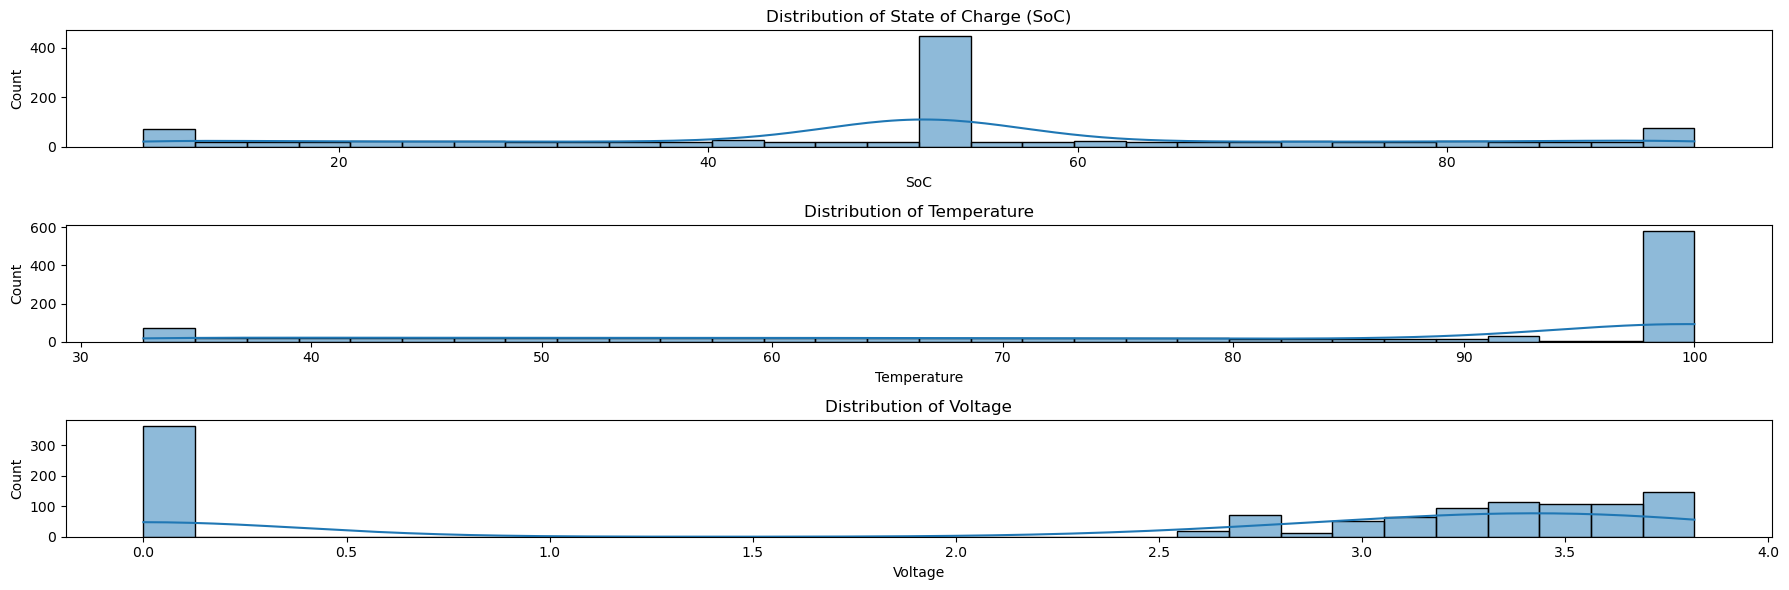

In [46]:
plt.figure(figsize=(18, 6))

# SoC distribution
plt.subplot(3, 1, 1)
sns.histplot(df['SoC'], kde=True, bins=30)
plt.title('Distribution of State of Charge (SoC)')

# Temperature distribution
plt.subplot(3, 1, 2)
sns.histplot(df['Temperature'], kde=True, bins=30)
plt.title('Distribution of Temperature')

# Voltage distribution
plt.subplot(3, 1, 3)
sns.histplot(df['Voltage'], kde=True, bins=30)
plt.title('Distribution of Voltage')

plt.tight_layout()
plt.show()


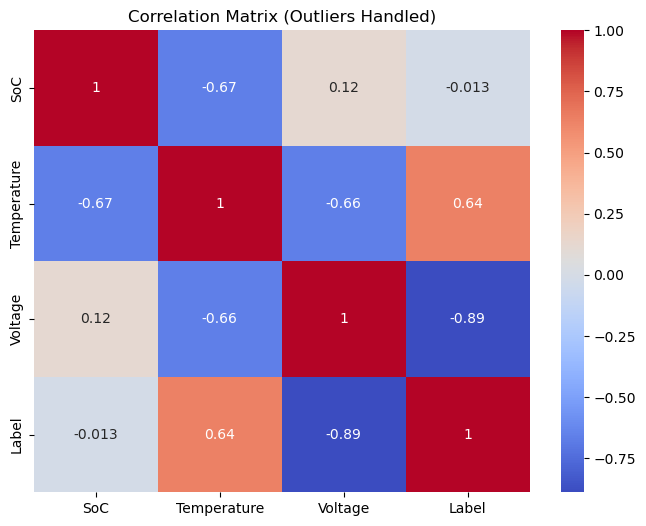

In [47]:
plt.figure(figsize=(8, 6))
corr_matrix = df[['SoC', 'Temperature', 'Voltage', 'Label']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix (Outliers Handled)')
plt.show()

## Step 2: Define Fire Risk Thresholds

In [48]:
temp_threshold = 77
voltage_low_threshold = 3.0
voltage_high_threshold = 4.2
soc_low_threshold = 10
soc_high_threshold = 90

# Step 3: Analyze the Dataset and Add Fire Risk Column

### Conditions for Fire Risk

In [49]:
def create_features(df):
    # Original features
    features = df[['SoC', 'Temperature', 'Voltage']].copy()
    
    # Add interaction terms
    features['Temp_Voltage'] = df['Temperature'] * df['Voltage']
    features['Temp_SoC'] = df['Temperature'] * df['SoC']
    features['Voltage_SoC'] = df['Voltage'] * df['SoC']
    
    # Add polynomial terms
    features['Temp_Squared'] = df['Temperature'] ** 2
    features['Voltage_Squared'] = df['Voltage'] ** 2
    features['SoC_Squared'] = df['SoC'] ** 2
    
    # Add threshold-based features
    features['High_Temp'] = (df['Temperature'] > 45).astype(int)
    features['Low_Voltage'] = (df['Voltage'] < 2.5).astype(int)
    features['High_Voltage'] = (df['Voltage'] > 4.2).astype(int)
    features['Low_SoC'] = (df['SoC'] < 20).astype(int)
    features['High_SoC'] = (df['SoC'] > 90).astype(int)
    
    return features

In [50]:
def calculate_fire_risk_score(df):
    risk_score = np.zeros(len(df))
    
    # Temperature risk (exponential increase after threshold)
    temp_risk = np.exp((df['Temperature'] - 45) / 10) / np.exp(5.5)  # Normalized
    risk_score += np.clip(temp_risk, 0, 0.4)
    
    # Voltage risk (both low and high voltage are risky)
    voltage_low_risk = np.exp((2.5 - df['Voltage']) * 2) / np.exp(5)
    voltage_high_risk = np.exp((df['Voltage'] - 4.2) * 2) / np.exp(5)
    risk_score += np.clip(voltage_low_risk + voltage_high_risk, 0, 0.3)
    
    # SoC risk (both very low and very high are risky)
    soc_low_risk = np.exp((20 - df['SoC']) / 20) / np.exp(1)
    soc_high_risk = np.exp((df['SoC'] - 90) / 10) / np.exp(1)
    risk_score += np.clip(soc_low_risk + soc_high_risk, 0, 0.3)
    
    # Normalize to [0, 1]
    risk_score = np.clip(risk_score, 0, 1)
    
    # Assign to new column
    df['Fire Risk Score'] = risk_score
    
    # Print summary statistics of the risk scores
    print("\nFire Risk Score Statistics:")
    print(df['Fire Risk Score'].describe())
    
    # Print distribution of risk scores
    print("\nRisk Score Distribution:")
    risk_bins = pd.cut(df['Fire Risk Score'], 
                      bins=[0, 0.2, 0.4, 0.6, 0.8, 1.0],
                      labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])
    print(risk_bins.value_counts().sort_index())
    
    return df['Fire Risk Score']

## Step 5: Train Model to Predict Fire Risk

In [51]:
# Create features and target
X = create_features(df)
y = calculate_fire_risk_score(df)

# Optional: Print some examples
print("\nSample data with Fire Risk Scores:")
print(df[['Temperature', 'Voltage', 'SoC', 'Fire Risk Score']].head(10).round(3))


Fire Risk Score Statistics:
count    1152.000000
mean        0.489675
std         0.268438
min         0.076691
25%         0.229468
50%         0.488522
75%         0.783542
max         1.000000
Name: Fire Risk Score, dtype: float64

Risk Score Distribution:
Fire Risk Score
Very Low     262
Low          208
Medium       178
High         488
Very High     16
Name: count, dtype: int64

Sample data with Fire Risk Scores:
   Temperature  Voltage     SoC  Fire Risk Score
0       32.721    3.818  93.385            0.305
1       32.721    3.818  93.385            0.305
2       32.721    3.818  93.385            0.305
3       32.721    3.818  93.385            0.305
4       32.721    3.818  93.385            0.305
5       32.721    3.818  93.385            0.305
6       32.721    3.818  93.385            0.305
7       32.721    3.818  93.385            0.305
8       32.721    3.818  93.385            0.305
9       32.721    3.818  92.558            0.305


In [52]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [53]:
# Scale the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Model Training and Evaluation

### Define a Function to Evaluate Models

In [54]:
def evaluate_model(model, X_train, y_train, X_test, y_test, threshold=0.5):
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    print(f"Cross-Validation MSE: {np.mean(-cv_scores):.4f} (±{np.std(cv_scores):.4f})")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"  Test MSE: {mse:.4f}")
    print(f"  Test R2: {r2:.4f}")
    
    # Classification metrics
    y_pred_class = (y_pred >= threshold).astype(int)
    cm = confusion_matrix(y_test >= threshold, y_pred_class)
    print("  Confusion Matrix:\n", cm)
    print("  Classification Report:\n", classification_report(y_test >= threshold, y_pred_class))
    
    # ROC Curve and AUC
    fpr, tpr, thresholds = roc_curve(y_test >= threshold, y_pred)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()
    
    print("-" * 60)

## Hyperparameter Tuning with GridSearchCV

In [55]:
# Define models
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(random_state=42),
    "SVR": SVR(),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42)
}

# Define parameter distributions
param_distributions = {
    'Linear Regression': {},
    'Random Forest': {
        'n_estimators': [100, 200],
        'max_depth': [10, 15, 20],
        'min_samples_split': [10, 20],
        'min_samples_leaf': [2, 4],
        'max_features': ['sqrt', 'log2']
    },
    'SVR': {
        'C': [0.1, 1, 10, 100],
        'kernel': ['rbf', 'linear'],
        'gamma': ['scale', 'auto', 0.1, 1]
    },
    'Gradient Boosting': {
        'n_estimators': [50, 100, 150],
        'learning_rate': [0.01, 0.05, 0.1],
        'max_depth': [2, 3, 4],
        'subsample': [0.6, 0.8, 1.0],
        'min_samples_split': [5, 10],
        'min_samples_leaf': [2, 4]
    }
}

# Split data into training and validation sets
X_train_split, X_val, y_train_split, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Dictionary to store best models
best_models = {}

# Hyperparameter tuning with GridSearchCV
for name, model in models.items():
    print(f"Tuning {name}:")
    if param_distributions[name]:
        grid_search = GridSearchCV(
            model,
            param_distributions[name],
            cv=5,
            scoring='neg_mean_squared_error',
            n_jobs=-1
        )
        grid_search.fit(X_train_split, y_train_split)
        print("Best Parameters:")
        print(grid_search.best_params_)
        best_models[name] = grid_search.best_estimator_
    else:
        model.fit(X_train_split, y_train_split)
        best_models[name] = model

# Evaluate models and select the best one
best_model_name = None
best_model = None
best_mse = float('inf')

for name, model in best_models.items():
    print(f"{name}:")
    y_val_pred = model.predict(X_val)
    val_mse = mean_squared_error(y_val, y_val_pred)
    print(f"Validation MSE for {name}: {val_mse:.4f}")

    if val_mse < best_mse:
        best_mse = val_mse
        best_model_name = name
        best_model = model

print(f"Best Model: {best_model_name}")
print(f"Best Validation MSE: {best_mse:.4f}")

# Final evaluation on test set
y_pred_best = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred_best)
r2 = r2_score(y_test, y_pred_best)
print(f"Test MSE for Best Model: {mse:.4f}")
print(f"Test R2 for Best Model: {r2:.4f}")


Tuning Linear Regression:
Tuning Random Forest:
Best Parameters:
{'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}
Tuning SVR:
Best Parameters:
{'C': 1, 'gamma': 'scale', 'kernel': 'linear'}
Tuning Gradient Boosting:
Best Parameters:
{'learning_rate': 0.05, 'max_depth': 4, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 150, 'subsample': 0.6}
Linear Regression:
Validation MSE for Linear Regression: 0.0009
Random Forest:
Validation MSE for Random Forest: 0.0002
SVR:
Validation MSE for SVR: 0.0022
Gradient Boosting:
Validation MSE for Gradient Boosting: 0.0000
Best Model: Gradient Boosting
Best Validation MSE: 0.0000
Test MSE for Best Model: 0.0000
Test R2 for Best Model: 0.9996


In [58]:
# Create DataFrame with actual and predicted values
results_df = pd.DataFrame({
    'Actual_Risk': y_test,
    'Predicted_Risk': y_pred_best,
    'Difference': np.abs(y_test - y_pred_best)
})

# Add original features for analysis
test_features = pd.DataFrame(X_test, columns=X.columns)
results_df = pd.concat([results_df, test_features], axis=1)

# Add some useful statistics
print("\nPrediction Analysis:")
print("-" * 50)
print("\nSummary Statistics of Predictions:")
print(results_df[['Actual_Risk', 'Predicted_Risk', 'Difference']].describe())

# Show distribution of predictions
print("\nDistribution of Predictions:")
print(pd.cut(results_df['Predicted_Risk'], 
            bins=[0, 0.2, 0.4, 0.6, 0.8, 1.0], 
            labels=['Very Low', 'Low', 'Medium', 'High', 'Very High']).value_counts())

# Show some example predictions
print("\nSample Predictions (10 random examples):")
sample_results = results_df.sample(10)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
print(sample_results.round(3))

# Print cases with largest prediction errors
print("\nCases with Largest Prediction Errors:")
print(results_df.nlargest(5, 'Difference').round(3))

# Save results to CSV for further analysis
results_df.to_csv('model/prediction_analysis.csv', index=False)
print("\nDetailed results saved to 'prediction_analysis.csv'")


Prediction Analysis:
--------------------------------------------------

Summary Statistics of Predictions:
       Actual_Risk  Predicted_Risk  Difference
count   231.000000      231.000000  231.000000
mean      0.469321        0.468889    0.002511
std       0.269315        0.268961    0.005111
min       0.076904        0.080502    0.000009
25%       0.211422        0.210236    0.000107
50%       0.488343        0.488509    0.000628
75%       0.783542        0.783435    0.002714
max       1.000000        0.989581    0.043546

Distribution of Predictions:
Predicted_Risk
High         90
Very Low     57
Low          47
Medium       34
Very High     3
Name: count, dtype: int64

Sample Predictions (10 random examples):
     Actual_Risk  Predicted_Risk  Difference    SoC  Temperature  Voltage  \
92           NaN             NaN         NaN  1.944       -2.006    0.878   
939        0.784           0.783         0.0    NaN          NaN      NaN   
90           NaN             NaN         NaN

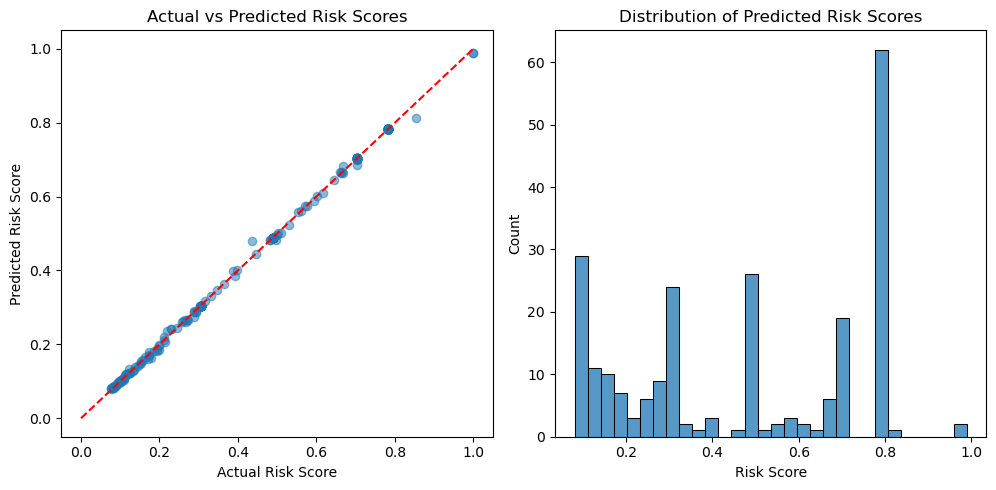

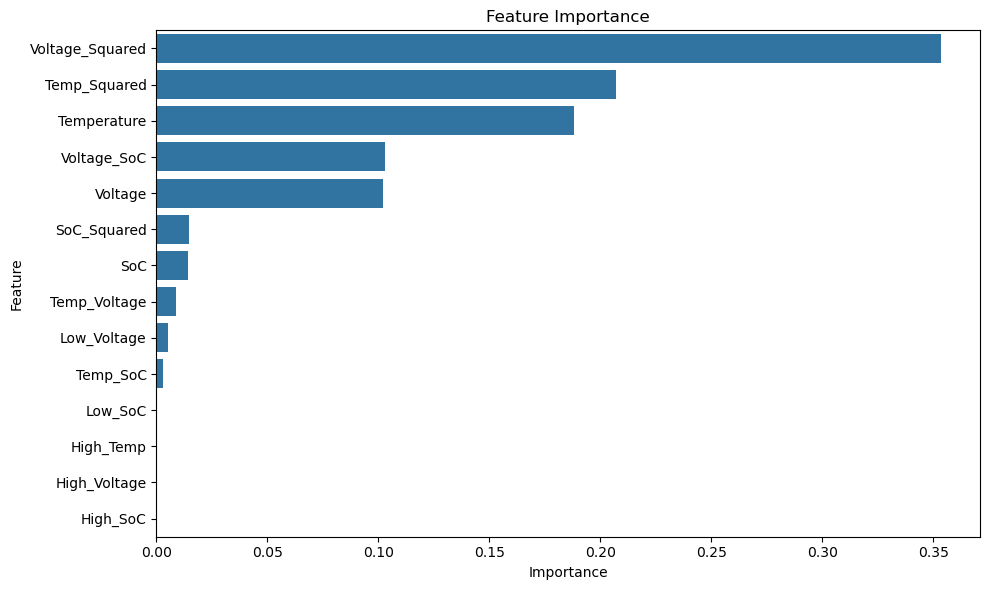

In [63]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create visualization subplot
plt.figure(figsize=(15, 5))

# Plot 1: Actual vs Predicted
plt.subplot(131)
plt.scatter(y_test, y_pred_best, alpha=0.5)
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel('Actual Risk Score')
plt.ylabel('Predicted Risk Score')
plt.title('Actual vs Predicted Risk Scores')

# Plot 2: Distribution of predictions
plt.subplot(132)
sns.histplot(data=results_df, x='Predicted_Risk', bins=30)
plt.title('Distribution of Predicted Risk Scores')
plt.xlabel('Risk Score')

plt.tight_layout()
plt.show()

# Feature importance plot
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance, x='Importance', y='Feature')
plt.title('Feature Importance')
plt.tight_layout()
plt.show()

In [60]:
# Create test cases
test_cases = pd.DataFrame({
    'Temperature': [25, 50, 75, 30, 60, 40, 80, 35, 45, 70],  # Mix of normal and high temperatures
    'Voltage': [3.2, 2.0, 4.5, 3.8, 2.3, 3.5, 4.8, 3.0, 4.0, 2.8],  # Mix of normal, low and high voltages
    'SoC': [50, 15, 95, 60, 25, 75, 90, 40, 85, 10]  # Mix of normal, low and high SoC values
})

# Create features for test cases using the same feature engineering
def create_test_features(df):
    features = df[['SoC', 'Temperature', 'Voltage']].copy()
    
    # Add interaction terms
    features['Temp_Voltage'] = df['Temperature'] * df['Voltage']
    features['Temp_SoC'] = df['Temperature'] * df['SoC']
    features['Voltage_SoC'] = df['Voltage'] * df['SoC']
    
    # Add polynomial terms
    features['Temp_Squared'] = df['Temperature'] ** 2
    features['Voltage_Squared'] = df['Voltage'] ** 2
    features['SoC_Squared'] = df['SoC'] ** 2
    
    # Add threshold-based features
    features['High_Temp'] = (df['Temperature'] > 45).astype(int)
    features['Low_Voltage'] = (df['Voltage'] < 2.5).astype(int)
    features['High_Voltage'] = (df['Voltage'] > 4.2).astype(int)
    features['Low_SoC'] = (df['SoC'] < 20).astype(int)
    features['High_SoC'] = (df['SoC'] > 90).astype(int)
    
    return features

# Process test cases
X_test_cases = create_test_features(test_cases)
X_test_cases_scaled = scaler.transform(X_test_cases)
y_pred_test = best_model.predict(X_test_cases_scaled)

# Add predictions to test cases
test_cases['Predicted_Risk'] = y_pred_test

# Add risk level categorization
def get_risk_level(score):
    if score <= 0.2:
        return 'Very Low'
    elif score <= 0.4:
        return 'Low'
    elif score <= 0.6:
        return 'Medium'
    elif score <= 0.8:
        return 'High'
    else:
        return 'Very High'

test_cases['Risk_Level'] = test_cases['Predicted_Risk'].apply(get_risk_level)

# Display results
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
print("\nTest Case Results:")
print("-" * 80)
print(test_cases.round(3))

# Summary statistics
print("\nRisk Level Distribution:")
print(test_cases['Risk_Level'].value_counts())



Test Case Results:
--------------------------------------------------------------------------------
   Temperature  Voltage  SoC  Predicted_Risk Risk_Level
0           25      3.2   50           0.389        Low
1           50      2.0   15           0.613       High
2           75      4.5   95           0.314        Low
3           30      3.8   60           0.094   Very Low
4           60      2.3   25           0.416     Medium
5           40      3.5   75           0.127   Very Low
6           80      4.8   90           0.324        Low
7           35      3.0   40           0.397        Low
8           45      4.0   85           0.243        Low
9           70      2.8   10           0.510     Medium

Risk Level Distribution:
Risk_Level
Low         5
Very Low    2
Medium      2
High        1
Name: count, dtype: int64


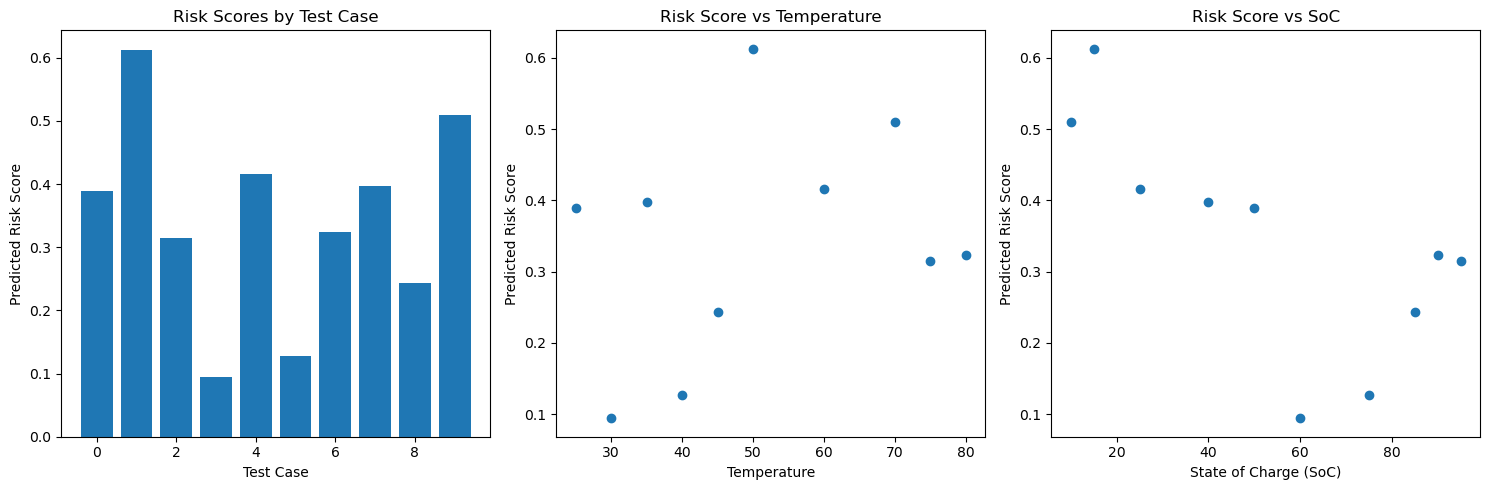


High Risk Cases (Risk Score > 0.6):
--------------------------------------------------------------------------------
   Temperature  Voltage  SoC  Predicted_Risk Risk_Level
1           50      2.0   15           0.613       High

Correlation with Risk Score:
--------------------------------------------------------------------------------
Predicted_Risk    1.000000
Temperature       0.302324
Voltage          -0.632845
SoC              -0.703370
Name: Predicted_Risk, dtype: float64


In [61]:
# Visualize results
plt.figure(figsize=(15, 5))

# Plot 1: Risk scores for each test case
plt.subplot(131)
plt.bar(range(len(test_cases)), test_cases['Predicted_Risk'])
plt.xlabel('Test Case')
plt.ylabel('Predicted Risk Score')
plt.title('Risk Scores by Test Case')

# Plot 2: Risk scores vs Temperature
plt.subplot(132)
plt.scatter(test_cases['Temperature'], test_cases['Predicted_Risk'])
plt.xlabel('Temperature')
plt.ylabel('Predicted Risk Score')
plt.title('Risk Score vs Temperature')

# Plot 3: Risk scores vs SoC
plt.subplot(133)
plt.scatter(test_cases['SoC'], test_cases['Predicted_Risk'])
plt.xlabel('State of Charge (SoC)')
plt.ylabel('Predicted Risk Score')
plt.title('Risk Score vs SoC')

plt.tight_layout()
plt.show()

# Print detailed analysis for high-risk cases
print("\nHigh Risk Cases (Risk Score > 0.6):")
print("-" * 80)
high_risk_cases = test_cases[test_cases['Predicted_Risk'] > 0.6]
if len(high_risk_cases) > 0:
    print(high_risk_cases.round(3))
else:
    print("No high risk cases found in the test set")

# Print correlation analysis
print("\nCorrelation with Risk Score:")
print("-" * 80)
correlations = test_cases[['Temperature', 'Voltage', 'SoC', 'Predicted_Risk']].corr()['Predicted_Risk'].sort_values(ascending=False)
print(correlations)

## Export Pickle File

In [62]:
# Create the 'model' directory if it doesn't exist
model_dir = "model"
os.makedirs(model_dir, exist_ok=True)

# Export the model
with open(os.path.join(model_dir, 'fire_risk_model.pkl'), 'wb') as file:
    pickle.dump(best_model, file)